In [1]:
# Basic Libraries
import sys
import time
import gc
import random
import copy 
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")

import networks as nets  # Contains RNNs
import net_helpers
import mpn_tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
print(torch.__version__)

2.5.1


In [3]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', 'x', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]

In [4]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict = {}

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygofamily' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "vanilla"

# suffix for saving images
# inputadd, Wfix, WL2, hL2
# inputrandom, Wtrain
# noise001
# largeregularization
# trainetalambda

mpn_depth = 1
n_hidden = 200

hyp_dict['addon_name'] = "Wtrain+WL2+hL2+reg1e3"
hyp_dict['addon_name'] += f"+hidden{n_hidden}"

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': True, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False,
        'label_strength': False, 
        'long_delay': 'normal',
        'long_response': 'normal',
        'long_stimulus': 'normal', 
        'long_fixation': 'normal', 
        'adjust_task_prop': True,
        'adjust_task_decay': 0.9, 
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 128,
        'batch_size': 128,
        'gradient_clip': 10,
        'valid_n_batch': 100,
        'n_datasets': 10000, # Number of distinct batches
        'valid_check': None, 
        'n_epochs_per_set': 1, # longer/shorter training
        'weight_reg': 'L2',
        'activity_reg': 'L2', 
        'reg_lambda': 1e-3,

        'scheduler': {
            'type': 'ReduceLROnPlateau',  # or 'StepLR'
            'mode': 'min',                # for ReduceLROnPlateau
            'factor': 0.5,                # factor to reduce LR
            'patience': 10,                # epochs to wait before reducing LR
            'min_lr': 1e-8,
            'step_size': 30,              # for StepLR (step every 30 datasets)
            'gamma': 0.1                  # for StepLR (multiply LR by 0.1)
        },
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'linear_embed': 200, 
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': train_params["n_epochs_per_set"],
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': True, 
        'input_layer_add_trainable': True, # revise this is effectively to [randomize_inputs], tune this
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        'acc_measure': 'stimulus', 
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': False,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 4000, # ms, sets lambda
            'lam_train': False,
            'W_freeze': False, # different combination with [input_layer_add_trainable]
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # Ensure the two options are *not* activated at the same time
    assert not (task_params["randomize_inputs"] and net_params["input_layer_add"]), (
        "task_params['randomize_inputs'] and net_params['input_layer_add'] cannot both be True."
    )

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = mpn_tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = mpn_tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 346
Fixation_off: True; Task_info: True
Rules: ['delaygo', 'delayanti']
  Input size 8, Output size 3
Using CUDA...


In [5]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [6]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim" # or "resp" 

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = mpn_tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix
    )
    _, test_trials, test_rule_idxs = test_trials_extra

    # generate test input data with separate period extension to obtain fixed points information
    task_params_longdelay = copy.deepcopy(task_params)
    task_params_longdelay["long_delay"] = "long"
    test_data_longdelay, test_trials_extra_longdelay = mpn_tasks.generate_trials_wrap(task_params_longdelay, test_n_batch, \
                                                                                      rules=task_params_longdelay['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longdelay, test_rule_idxs_longdelay = test_trials_extra_longdelay

    task_params_longresponse = copy.deepcopy(task_params)
    task_params_longresponse["long_response"] = "long"
    test_data_longresponse, test_trials_extra_longresponse = mpn_tasks.generate_trials_wrap(task_params_longresponse, test_n_batch, \
                                                                                      rules=task_params_longresponse['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longresponse, test_rule_idxs_longresponse = test_trials_extra_longresponse

    task_params_longstimulus = copy.deepcopy(task_params)
    task_params_longstimulus["long_stimulus"] = "long"
    test_data_longstimulus, test_trials_extra_longstimulus = mpn_tasks.generate_trials_wrap(task_params_longstimulus, test_n_batch, \
                                                                                      rules=task_params_longstimulus['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longstimulus, test_rule_idxs_longstimulus = test_trials_extra_longstimulus

    task_params_longfixation = copy.deepcopy(task_params)
    task_params_longfixation["long_fixation"] = "long"
    test_data_longfixation, test_trials_extra_longfixation = mpn_tasks.generate_trials_wrap(task_params_longfixation, test_n_batch, \
                                                                                      rules=task_params_longfixation['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longfixation, test_rule_idxs_longfixation = test_trials_extra_longfixation
    

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    def generate_response_stimulus(task_params, test_trials): 
        """
        """
        labels_resp, labels_stim = [], []
        for rule_idx, rule in enumerate(task_params['rules']):
            print(rule)
            if rule in accept_rules:
                if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                    labels.append(test_trials[rule_idx].meta['matches'])
                else:
                    labels_resp.append(test_trials[rule_idx].meta['resp1'])
                    labels_stim.append(test_trials[rule_idx].meta['stim1']) 
    
            else:
                raise NotImplementedError()
                
        labels_resp = np.concatenate(labels_resp, axis=0).reshape(-1,1)
        labels_stim = np.concatenate(labels_stim, axis=0).reshape(-1,1)

        return labels_resp, labels_stim

    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)

labels = labels_stim if color_by == "stim" else labels_resp
    
test_input, test_output, test_mask = test_data
test_input_longfixation, test_output_longfixation, test_mask_longfixation = test_data_longfixation
test_input_longstimulus, test_output_longstimulus, test_mask_longstimulus = test_data_longstimulus
test_input_longdelay, test_output_longdelay, test_mask_longdelay = test_data_longdelay
test_input_longresponse, test_output_longresponse, test_mask_longresponse = test_data_longresponse

print(f"test_input_longdelay.shape: {test_input_longdelay.shape}")
print(f"test_output_longdelay.shape: {test_output_longdelay.shape}")
print(f"test_input_longresponse.shape: {test_input_longresponse.shape}")
print(f"test_output_longresponse.shape: {test_output_longresponse.shape}")
print(f"test_input_longstimulus.shape: {test_input_longstimulus.shape}")
print(f"test_output_longstimulus.shape: {test_output_longstimulus.shape}")

# permutation = np.random.permutation(test_input.shape[0])
# test_input = test_input[permutation]
# test_output = test_output[permutation]
# test_mask = test_mask[permutation]
# labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

# Total number of batches, might be different than test_n_batch
# this should be the same regardless of variety of test_input
n_batch_all = test_input_np.shape[0] 

def find_task(task_params, test_input_np, shift_index):
    """
    """
    test_task = [] # which task
    for batch_idx in range(test_input_np.shape[0]):
        
        if task_params["randomize_inputs"]: 
            test_input_np_ = test_input_np @ np.linalg.pinv(task_params["randomize_matrix"])
        else: 
            test_input_np_ = test_input_np
            
        task_label = test_input_np_[batch_idx, 0, 6-shift_index:]
        # task_label_index = np.where(task_label == 1)[0][0]
        
        # tol = 1e-3      
        # mask = np.isclose(task_label, 1, atol=tol)
        task_label = np.asarray(task_label)       
        dist = np.abs(task_label - 1)     
        mask = dist == dist.min() 
        
        indices = np.where(mask)[0]
        
        if indices.size:                
            task_label_index = indices[0]   
        else:
            raise ValueError("No entry close enough to 1 found")
            
        test_task.append(task_label_index)

    return test_task  

test_task = find_task(task_params, test_input_np, shift_index)

test_task_longfixation = find_task(task_params_longfixation, test_input_longfixation.detach().cpu().numpy(), shift_index)
test_task_longstimulus = find_task(task_params_longstimulus, test_input_longstimulus.detach().cpu().numpy(), shift_index)
test_task_longdelay = find_task(task_params_longdelay, test_input_longdelay.detach().cpu().numpy(), shift_index)
test_task_longresponse = find_task(task_params_longresponse, test_input_longresponse.detach().cpu().numpy(), shift_index)

Align ['delaygo', 'delayanti'] With Same Time
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
rng reset with seed 8103
delaygo
delayanti
test_input_longdelay.shape: torch.Size([200, 311, 8])
test_output_longdelay.shape: torch.Size([200, 311, 3])
test_input_longresponse.shape: torch.Size([200, 321, 8])
test_output_longresponse.shape: torch.Size([200, 321, 3])
test_input_longstimulus.shape: torch.Size([200, 311, 8])
test_output_longstimulus.shape: torch.Size([200, 311, 3])


In [7]:
# we use net at different training stage on the same test_input
start_time = time.time()
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst,\
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst), _ = net_helpers.train_network(params, device=device, verbose=verbose,
                                                                                              train=train, hyp_dict=hyp_dict,
                                                                                              netFunction=netFunction,
                                                                                              test_input=[test_input, 
                                                                                                          test_input_longfixation,
                                                                                                          test_input_longstimulus, 
                                                                                                          test_input_longdelay,
                                                                                                          test_input_longresponse],
                                                                                              print_frequency=100)

end_time = time.time()
print(f"Running Time: {end_time - start_time}")
counter_lst = [x * epoch_multiply + 1 for x in counter_lst] # avoid log plot issue    

Vanilla RNN:
  n_neurons - input: 8, hidden: 200, output: 3
  input layer: trainable // rec layer: trainable // TBPTT: False
 output layer: trainable
  Act: tanh
  Leaky updates, timescale 200 ms (old: 0.8 new: 0.2)
Trainable parameters: 42,400
W_input: (200, 8)
W_rec: (200, 200)
Parameter containing:
tensor([[-0.0959,  0.0917, -0.1184,  ..., -0.0373,  0.0273, -0.1088],
        [ 0.0393,  0.0100, -0.0191,  ..., -0.0286,  0.1045, -0.0315],
        [-0.0321, -0.1120,  0.0894,  ...,  0.0288,  0.1122,  0.0549],
        ...,
        [-0.1020, -0.0945, -0.0599,  ...,  0.0797,  0.0427,  0.0068],
        [ 0.0862,  0.0390,  0.1027,  ..., -0.0371,  0.0827, -0.1217],
        [-0.0582,  0.1010, -0.0529,  ...,  0.0483, -0.0153, -0.0536]],
       requires_grad=True)
W_output: (3, 200)
b_hidden: (200,)
task_params['rules_probs']: [0.5 0.5]
Rule: delayanti
Rule delayanti seq_len 102, max_seq_len 102
inputs_all paddled: (128, 102, 8)
inputs_all: torch.Size([128, 102, 8])
========== Setup Parameters ==

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


valid_acc_history: [None, None, None, None]
Iter: 100, LR: 1.000e-03 - train_loss:1.742e-01, rounded train_acc:0.192, valid_loss:2.084e-01, rounded valid_acc:0.194
task_params['rules_probs']: [0.56844248 0.43155752]
Rule: delaygo
Rule delaygo seq_len 107, max_seq_len 107
inputs_all paddled: (128, 107, 8)
inputs_all: torch.Size([128, 107, 8])
valid_acc_history: [None, None, None, None]
Iter: 200, LR: 1.000e-03 - train_loss:1.898e-01, rounded train_acc:0.258, valid_loss:1.485e-01, rounded valid_acc:0.540
task_params['rules_probs']: [0.64453601 0.35546399]
Rule: delayanti
Rule delayanti seq_len 105, max_seq_len 105
inputs_all paddled: (128, 105, 8)
inputs_all: torch.Size([128, 105, 8])
valid_acc_history: [None, None, None, None]
Iter: 300, LR: 1.000e-03 - train_loss:1.336e-01, rounded train_acc:0.754, valid_loss:1.348e-01, rounded valid_acc:0.614
task_params['rules_probs']: [0.53557797 0.46442203]
Rule: delaygo
Rule delaygo seq_len 98, max_seq_len 98
inputs_all paddled: (128, 98, 8)
input

In [8]:
hyp_dict['addon_name'] += "rnn"

In [9]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    # ind = len(marker_lst)-1 
    ind = -1
    # network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    # print(f"Using network at {network_at_percent}%")
    # by default using the first test_input 
    net_out = netout_lst[0][ind]
    db = db_lst[0][ind]
    W_output = Woutput_lst[ind]

In [10]:
def plot_input_output(test_input_np, net_out, test_output_np, test_task=None, tag="", batch_num=5, label=None):
    """
    """
    test_input_np = helper.to_ndarray(test_input_np)
    net_out = helper.to_ndarray(net_out)
    test_output_np = helper.to_ndarray(test_output_np)
    
    fig_all, axs_all = plt.subplots(batch_num,2,figsize=(4*2,batch_num*2))
    
    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])
    
    else:
        for batch_idx in range(batch_num):
            for out_idx in range(test_output_np.shape[-1]):
                axs_all[batch_idx,0].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx], label=out_idx)
                axs_all[batch_idx,0].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                if test_task is not None: 
                    outname = f"{task_params['rules'][test_task[batch_idx]]}; {tag}"
                    axs_all[batch_idx,0].set_title(outname)
                axs_all[batch_idx,0].legend()
    
            input_batch = test_input_np[batch_idx,:,:]
            if task_params["randomize_inputs"]: 
                input_batch = input_batch @ np.linalg.pinv(task_params["randomize_matrix"])
            for inp_idx in range(input_batch.shape[-1]):
                axs_all[batch_idx,1].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                if test_task is not None: 
                    axs_all[batch_idx,1].set_title(f"{task_params['rules'][test_task[batch_idx]]}; {tag}")
                axs_all[batch_idx,1].legend()

    for ax in axs_all.flatten(): 
        ax.set_ylim([-2, 2])
    fig_all.tight_layout()
    fig_all.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_seed{seed}_{hyp_dict['addon_name']}_{tag}.png", dpi=300)

    return fig_all, axs_all

(<Figure size 800x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>]], dtype=object))

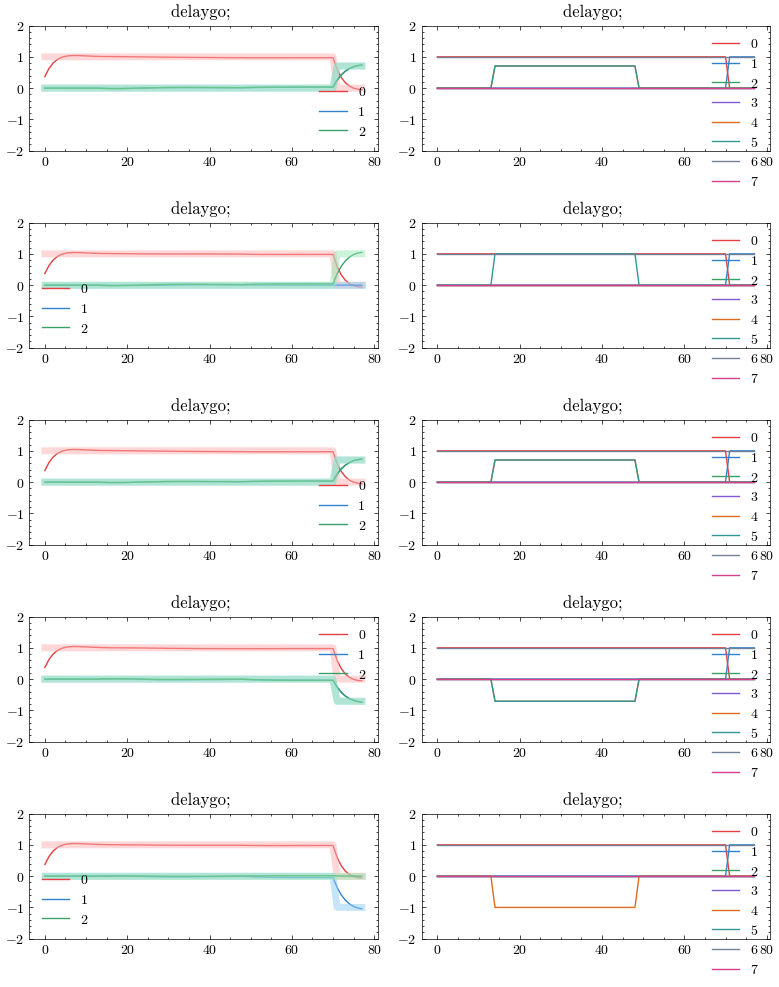

In [11]:
plot_input_output(test_input_np, net_out, test_output_np, test_task, tag="")

In [12]:
def make_label_task_comb(task_params, test_trials, test_task, color_by="stim"):
    """
    """
    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)
    labels_ = labels_stim if color_by == "stim" else labels_resp
    # pair: [label_first_dim, task_id] for each trial
    return np.column_stack((labels_[:, 0], test_task))

label_task_comb_longdelay = make_label_task_comb(
    task_params_longdelay, test_trials_longdelay, test_task_longdelay, color_by=color_by
)

label_task_comb_longresponse = make_label_task_comb(
    task_params_longresponse, test_trials_longresponse, test_task_longresponse, color_by=color_by
)

label_task_comb_longstimulus = make_label_task_comb(
    task_params_longstimulus, test_trials_longstimulus, test_task_longstimulus, color_by=color_by
)

label_task_comb_longfixation = make_label_task_comb(
    task_params_longfixation, test_trials_longfixation, test_task_longfixation, color_by=color_by
)

label_task_comb = make_label_task_comb(
    task_params, test_trials, test_task, color_by=color_by
)

delaygo
delayanti
delaygo
delayanti
delaygo
delayanti
delaygo
delayanti
delaygo
delayanti


In [13]:
def analyze_similarity(Ms_orig, hs, net, net_params, label_task_comb, checktime, compare="modulation", moddim=0): 
    """
    """
    # print(f"compare: {compare}; moddim: {moddim}")
    inverse_modulation_ss_dt = []
    inverse_modulation_sr_dt = []
    inverse_modulation_st_ds = [[], []]
    modulation_save = [[],[]]
    modulation_save_time = [[],[]]
    hidden_save_time = [[],[]]

    if compare == "w_modulation":
        Ms_orig = Ms_orig * W[None,None,:,:]

    # same stimulus (effectively anti-response), different task
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 1])]
        ll = min(len(ind1), len(ind2))

        # M @ win: effective plastic sensitivity
        # How does the current memory (M) distort or amplify specific input channels?
        if compare in ("modulation", "w_modulation"):                 
            winadd = False if moddim == None else True
 
            if winadd: 
                if moddim == "Win": 
                    Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                    Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                else:
                    Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                    Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
            else:
                Ms1_change_stimulus = [(Ms_orig[ind1[i],checktime,:,:]).flatten() for i in range(ll)]
                Ms2_change_stimulus = [(Ms_orig[ind2[i],checktime,:,:]).flatten() for i in range(ll)]
                
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]

        # since we group by the same stimulus at the same task
        # the period is aligned in all trials of testing data
        # therefore the resulting modulation & hidden should be identical
        assert_sums_close(Ms1_change_stimulus, rtol=1e-3, atol=1e-3)
        assert_sums_close(Ms2_change_stimulus, rtol=1e-3, atol=1e-3)
        
        inverse_modulation_ss_dt.append(1 - cosine(Ms1_change_stimulus[0], Ms2_change_stimulus[0]))

        modulation_save[0].append(Ms1_change_stimulus[0])
        modulation_save[1].append(Ms2_change_stimulus[0])

        # modulation for one type of stimulus for two tasks
        Ms1_all = Ms_orig[ind1[0],:,:,:]
        Ms2_all = Ms_orig[ind2[0],:,:,:]
        h1_all = hs[ind1[0],:,:]
        h2_all = hs[ind2[0],:,:]
        # save the whole modulation trajectory for this stimulus (go and anti)
        modulation_save_time[0].append(Ms1_all)
        modulation_save_time[1].append(Ms2_all)
        hidden_save_time[0].append(h1_all)
        hidden_save_time[1].append(h2_all)

    # same response, different task 
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [(k + 4) % 8, 1])]
        ll = min(len(ind1), len(ind2))

        if compare in ("modulation", "w_modulation"): 
            winadd = False if moddim == None else True
 
            if winadd: 
                if moddim == "Win": 
                    Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                    Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                else:
                    Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                    Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
            else:
                Ms1_change_stimulus = [(Ms_orig[ind1[i],checktime,:,:]).flatten() for i in range(ll)]
                Ms2_change_stimulus = [(Ms_orig[ind2[i],checktime,:,:]).flatten() for i in range(ll)]
                
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]

        assert_sums_close(Ms1_change_stimulus, rtol=1e-3, atol=1e-3)
        assert_sums_close(Ms2_change_stimulus, rtol=1e-3, atol=1e-3)
        
        inverse_modulation_sr_dt.append(1 - cosine(Ms1_change_stimulus[0], Ms2_change_stimulus[0]))

    # same task, different stimulus 
    repeat = 100
    modulation_matrices_all = [] 
    for _ in range(repeat): 
        modulation_matrices = [
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan), 
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan)
        ]
        
        for i in range(len(modulation_save[0])):
            for j in range(i+1, len(modulation_save[0])):
                modulation_matrices[0][i,j] = 1 - cosine(modulation_save[0][i], modulation_save[0][j])
                modulation_matrices[1][i,j] = 1 - cosine(modulation_save[1][i], modulation_save[1][j])

        try: 
            modulation_matrices_all.append([np.nanmean(sample_non_nan(modulation_matrices[0], 8)),
                                            np.nanmean(sample_non_nan(modulation_matrices[1], 8))])
        except Exception as e:
            modulation_matrices_all.append([np.nan, np.nan])

    modulation_matrices_all = np.array(modulation_matrices_all)

    result = [[np.mean(inverse_modulation_ss_dt), np.std(inverse_modulation_ss_dt)], 
              [np.mean(inverse_modulation_sr_dt), np.std(inverse_modulation_sr_dt)], 
              [np.mean(modulation_matrices_all[:,0]), np.std(modulation_matrices_all[:,0])], 
              [np.mean(modulation_matrices_all[:,1]), np.std(modulation_matrices_all[:,1])]]

    return result, modulation_save_time, hidden_save_time

In [14]:
def sample_non_nan(arr, k):
    """
    Pick `k` distinct (non-NaN) numbers from a 2-D NumPy array.
    """
    pool = arr[~np.isnan(arr)]            # flatten & keep only real numbers
    if k > pool.size:                     # ensure enough unique values
        raise ValueError("k exceeds number of non-NaN entries.")
    return np.random.choice(pool, k, replace=False).tolist()


def assert_sums_close(arr_list, rtol=1e-5, atol=1e-8):
    """
    """
    assert len(arr_list) > 0, "Empty list."
    sums = np.array([np.sum(a) for a in arr_list], dtype=float)
    ref = sums[0]
    ok = np.isclose(sums, ref, rtol=rtol, atol=atol)

    if not np.all(ok):
        bad = np.where(~ok)[0]
        raise AssertionError(
            f"Sum mismatch at indices {bad.tolist()}.\n"
            f"ref_sum={ref}, bad_sums={sums[bad].tolist()}, all_sums={sums.tolist()}"
        )


In [15]:
def modulation_extraction_rnn(test_input, db, cuda=False):
    """
    Extracts modulation tensors from `db` and returns:
        Ms:      (batch, seq, features) reshaped version of M
        Ms_orig: original M (no reshape)
        hs:      (batch, seq, features) reshaped version of hidden
        bs:      bias vector/matrix as-is (or concatenated if list)
    """

    def _to_numpy(x):
        # Convert torch.Tensor -> numpy, otherwise np.asarray
        try:
            import torch
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
        except Exception:
            pass
        return np.asarray(x)

    def _concat_last(x):
        # If list/tuple of arrays: concatenate on last axis; else return as-is
        return np.concatenate(x, axis=-1) if isinstance(x, (list, tuple)) else x

    n_batch, max_seq_len = test_input.shape[0], test_input.shape[1]
    
    # hidden
    H_raw = _concat_last(_to_numpy(db[f"hidden"]))
    hs = H_raw.reshape(n_batch, max_seq_len, -1)

    return hs

In [16]:
# across training stage
result_attractor_all_h, result_attractor_all_m, result_attractor_all_wmwin = [], [], []
modulation_save_time = []
pr_all = [] 
test_input_long_all = [test_input, test_input_longfixation, test_input_longstimulus, 
                       test_input_longdelay, test_input_longresponse]
label_task_comb_long_all = [label_task_comb, label_task_comb_longfixation, label_task_comb_longstimulus, 
                            label_task_comb_longdelay, label_task_comb_longresponse]
# register the timestamps information for different long periods
time_stamps_usual, time_stamps_longfixation, time_stamps_longstimulus, time_stamps, time_stamps_longresponse = {}, {}, {}, {}, {}

for i in range(5): 
    for db_attractor in db_lst[i]:
        h_long = modulation_extraction_rnn(test_input_long_all[i], db_attractor)
        
        # to handle noise, find the time when fixation is off
        checktime_sample = test_input_long_all[i][0,:,0].detach().cpu()
        mask = checktime_sample < 0.5 
        idx = torch.nonzero(mask, as_tuple=False) 
        checktime_attractor = idx[0].item()  

        if i == 3: 
            time_stamps["delay_end"] = checktime_attractor - 1 # a little bit before the fixation off
        elif i == 4:
            time_stamps_longresponse["delay_end"] = checktime_attractor - 1
        elif i == 0: 
            time_stamps_usual["delay_end"] = checktime_attractor - 1
            cc = time_stamps_usual["delay_end"]
        elif i == 2: 
            time_stamps_longstimulus["delay_end"] = checktime_attractor - 1
        elif i == 1:
            time_stamps_longfixation["delay_end"] = checktime_attractor - 1

        if i == 0: 
            result_attractor_h, _, _ = analyze_similarity(np.zeros((200, 200, 200, 200), dtype=np.float32), h_long, net, net_params, label_task_comb_long_all[i], 
                                                            checktime=cc, compare="hidden")
            # result_attractor_m, m_save, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
            #                                                 checktime=cc, compare="modulation")
            # result_attractor_wmwin, _, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
            #                                                 checktime=cc, compare="w_modulation", moddim="Win")
            
            result_attractor_all_h.append(result_attractor_h)
            # result_attractor_all_m.append(result_attractor_m)
            # result_attractor_all_wmwin.append(result_attractor_wmwin)
            # modulation_save_time.append(m_save)

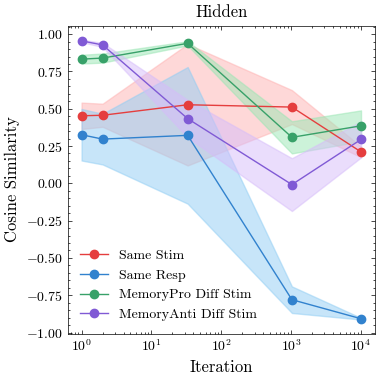

In [17]:
figattractor, axsattractor = plt.subplots(1,1,figsize=(4,4))
break_names = [
    "Same Stim",
    "Same Resp",
    "MemoryPro Diff Stim",
    "MemoryAnti Diff Stim",
]

def plot_mean_std(ax, x, mean, std, color, fill_color, label):
    ax.plot(x, mean, "-o", color=color, label=label)
    ax.fill_between(x, np.asarray(mean) - np.asarray(std), np.asarray(mean) + np.asarray(std),
                    alpha=0.5, color=fill_color)

# each entry: (results, axis_index)
panels = [
    (result_attractor_all_h, 0),
]

n_groups = len(result_attractor_all_h[0])  # same as your original len(result_attractor_all[0])

for i in range(n_groups):
    for results, ax_idx in panels:
        mean = [rs[i][0] for rs in results]
        std  = [rs[i][1] for rs in results]
        plot_mean_std(
            axsattractor,
            counter_lst,
            mean,
            std,
            color=c_vals[i],
            fill_color=c_vals_l[i],
            label=break_names[i],
        )

axsattractor.set_xscale("log")
axsattractor.legend()
axsattractor.set_ylabel("Cosine Similarity", fontsize=12)
axsattractor.set_xlabel("Iteration", fontsize=12)
    
axsattractor.set_title("Hidden", fontsize=12)

figattractor.tight_layout()
figattractor.savefig(
    f"./twotasks/attractor_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [18]:
woutput = net.W_output.detach().cpu().numpy()
hiddens = db_lst[0][-1]["hidden"]
outputs = hiddens @ woutput.T

-0.8954904
-0.90373755
-0.9093554
-0.90907717
-0.9141195
-0.9060854
-0.91221976
-0.9098977


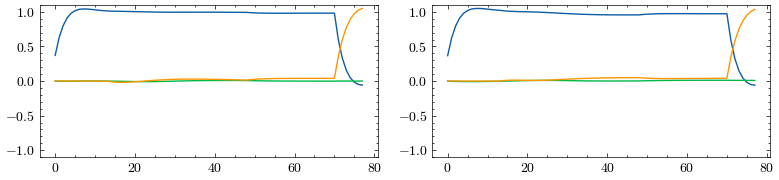

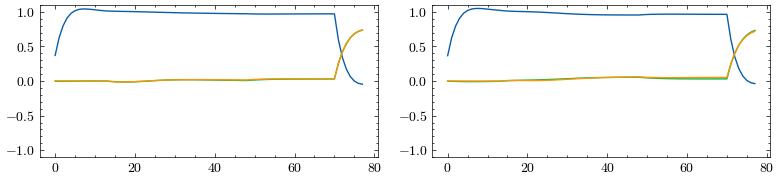

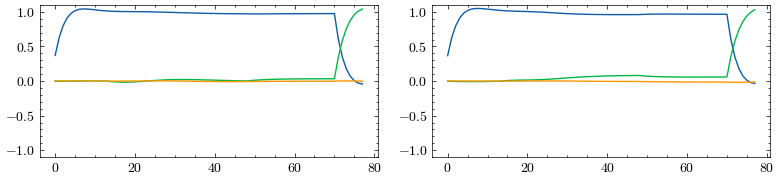

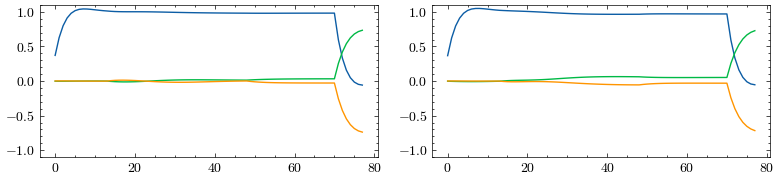

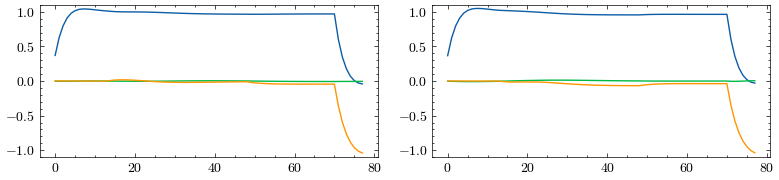

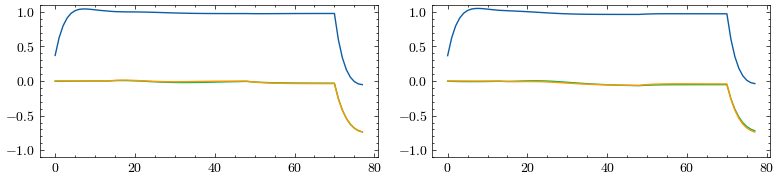

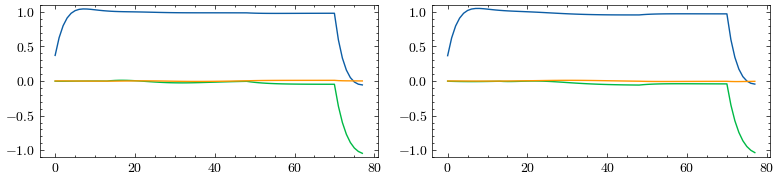

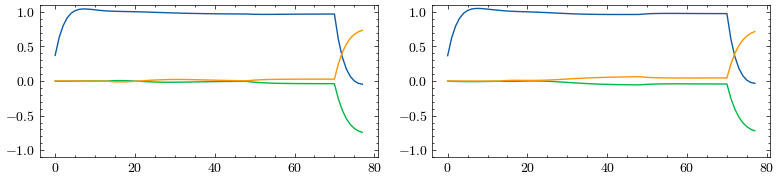

In [19]:
for k in range(8): 
    fig, axs = plt.subplots(1,2,figsize=(4*2,2))
    match1 = np.where(np.all(label_task_comb == np.array([k,0]), axis=1))[0]
    match2 = np.where(np.all(label_task_comb == np.array([(k+4)%8,1]), axis=1))[0]
    for j in range(3):
        axs[0].plot(outputs[match1[0],:,j])
    for j in range(3):
        axs[1].plot(outputs[match2[0],:,j])
    for ax in axs:
        ax.set_ylim([-1.1,1.1])

    fig.tight_layout()
    
    print(1-cosine(hiddens[match1[0],cc,:].flatten(), hiddens[match2[0],cc,:].flatten()))

In [20]:
def figure2A_pca_fve(
    H,
    task_id,
    periods,
    k=2,
    max_pcs=10,
    center="global",          # {"global", "none"}
    flatten="trial_time",     # currently only "trial_time"
    dtype=np.float64,
    return_cross_task=True,   # NEW
):
    """
    Figure 2A-style cross-period PCA explained-variance analysis.

    NEW: optionally compute a cross-task, cross-period FVE matrix across all (task, period)
         pairs and return it as `fve_k_all` (Q x Q). If you have 2 tasks each with P periods,
         Q=2P and fve_k_all is 2P x 2P.

    Returns
    -------
    results : dict
        results[task] = {
            "period_names": list[str] length P_task,
            "fve_k": np.ndarray (P_task, P_task), rows=target period X, cols=basis period Y,
            "evr_curves": np.ndarray (P_task, max_pcs),
            "pca": {period_name: {"components": (N, r), "singular_values": (r,), "mean": (N,), "evr": (r,)}}
        }
        plus, if return_cross_task:
        results["__cross_task__"] = {
            "labels": list[tuple(task, period_name)] length Q,
            "fve_k_all": np.ndarray (Q, Q), rows=target (task,period), cols=basis (task,period)
        }
    """
    # --- helper: convert torch -> numpy without requiring torch import
    if hasattr(H, "detach"):
        H_np = H.detach().cpu().numpy()
    else:
        H_np = np.asarray(H)
    H_np = H_np.astype(dtype, copy=False)

    task_id = np.asarray(task_id)
    B, T, N = H_np.shape

    def _get_period_matrix(H_task, t0, t1):
        X = H_task[:, t0:t1, :]  # (B_task, L, N)
        if flatten == "trial_time":
            X = X.reshape(-1, N)  # (B_task*L, N)
        else:
            raise ValueError(f"Unsupported flatten mode: {flatten}")
        return X

    def _center(X, mean=None):
        if center == "none":
            mu = np.zeros((X.shape[1],), dtype=X.dtype) if mean is None else mean
            return X, mu
        if mean is None:
            mu = X.mean(axis=0)
        return X - mu, mu

    def _pca_svd(X, r):
        """
        PCA via SVD on centered data X (M,N).
        Returns components V (N,r_eff), EVR (r_eff,), singular values (r_eff,).
        """
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        r_eff = min(r, Vt.shape[0])
        V = Vt[:r_eff, :].T  # (N, r_eff)
        S = S[:r_eff]

        M = X.shape[0]
        denom = (np.sum(X * X) / max(M - 1, 1))
        evals = (S * S) / max(M - 1, 1)
        evr = evals / denom if denom > 0 else np.zeros_like(evals)
        return V, S, evr

    def _fve_project(X, V):
        """
        Fraction of variance explained by projecting X onto span(V).
        X should be centered consistently with the PCA basis.
        V: (N, r)
        """
        tot = np.sum(X * X)
        if tot <= 0:
            return 0.0
        XV = X @ V
        Xhat = XV @ V.T
        num = np.sum(Xhat * Xhat)
        return float(num / tot)

    # -----------------------------
    # Per-task results (unchanged)
    # -----------------------------
    results = {}

    # For cross-task aggregation (NEW)
    all_labels = []          # list of (task, period_name)
    all_Xc = {}              # (task, period) -> centered matrix
    all_Vk = {}              # (task, period) -> top-k basis (N, k_eff)

    for task, per_dict in periods.items():
        idx = np.where(task_id == task)[0]
        if idx.size == 0:
            continue

        H_task = H_np[idx, :, :]  # (B_task, T, N)

        period_names = list(per_dict.keys())
        P = len(period_names)

        pca_info = {}
        X_period_centered = {}

        for pname in period_names:
            t0, t1 = per_dict[pname]
            if not (0 <= t0 < t1 <= T):
                raise ValueError(f"[{task}:{pname}] invalid period bounds {(t0,t1)} for T={T}")
            X = _get_period_matrix(H_task, t0, t1)
            Xc, mu = _center(X)
            X_period_centered[pname] = Xc

            V, S, evr = _pca_svd(Xc, r=max(max_pcs, k))
            pca_info[pname] = {
                "components": V,
                "singular_values": S,
                "mean": mu,
                "evr": evr,
            }

            # NEW: cache (task, period) for cross-task matrix
            if return_cross_task:
                key = (task, pname)
                all_labels.append(key)
                all_Xc[key] = Xc
                k_eff = min(k, V.shape[1])
                all_Vk[key] = V[:, :k_eff]  # top-k PCs for this (task, period)

        # intra-task cross-period FVE matrix (same as before)
        fve_k = np.zeros((P, P), dtype=dtype)
        for i, px in enumerate(period_names):
            Xc = X_period_centered[px]
            for j, py in enumerate(period_names):
                V = pca_info[py]["components"]
                r_eff = min(k, V.shape[1])
                fve_k[i, j] = _fve_project(Xc, V[:, :r_eff])

        # per-period EVR curves (same as before)
        evr_curves = np.zeros((P, max_pcs), dtype=dtype)
        for i, pname in enumerate(period_names):
            evr = pca_info[pname]["evr"]
            evr_curves[i, :min(max_pcs, evr.shape[0])] = evr[:min(max_pcs, evr.shape[0])]

        results[task] = {
            "period_names": period_names,
            "fve_k": fve_k,
            "evr_curves": evr_curves,
            "pca": pca_info,
        }

    # --------------------------------------------
    # Cross-task, cross-period FVE matrix (NEW)
    # --------------------------------------------
    if return_cross_task:
        # Keep a stable order (task insertion order from `periods`, then period order in each task)
        # all_labels already appended in that order.

        Q = len(all_labels)
        fve_k_all = np.zeros((Q, Q), dtype=dtype)

        for i, key_x in enumerate(all_labels):       # target
            Xc = all_Xc[key_x]
            for j, key_y in enumerate(all_labels):   # basis
                Vk = all_Vk[key_y]
                fve_k_all[i, j] = _fve_project(Xc, Vk)

        results["__cross_task__"] = {
            "labels": all_labels,      # rows/cols correspond to this list
            "fve_k_all": fve_k_all,    # (Q, Q); for 2 tasks with P periods each => 2P x 2P
        }

    return results


In [21]:
# across different timestamp 
def time_stamp_extract(test_input_long, time_stamps):
    stimulus_end = None 
    chosen_batch = 0
    while stimulus_end is None: 
        try: 
            input_part = test_input_long[chosen_batch,:,2:2+4].detach().cpu().numpy()
            input_part_sum = np.sum(input_part, axis=1)
            stimulus_end = np.where(input_part_sum > 0.5)[0][-1]
            stimulus_start = np.where(input_part_sum > 0.5)[0][0] - 1
        except IndexError: 
            chosen_batch += 1
    
    time_stamps["stimulus_start"] = stimulus_start + 1
    time_stamps["stimulus_end"] = stimulus_end + 1
    time_stamps["delay_start"] = stimulus_end + 1
    time_stamps["trial_end"] = len(input_part_sum) - 1
    time_stamps["fixation_end"] = stimulus_start
    time_stamps["fixation_start"] = 0 

    return time_stamps

time_stamps = time_stamp_extract(test_input_longdelay, time_stamps)
time_stamps_longresponse = time_stamp_extract(test_input_longresponse, time_stamps_longresponse)
time_stamps_usual = time_stamp_extract(test_input, time_stamps_usual)
time_stamps_longstimulus = time_stamp_extract(test_input_longstimulus, time_stamps_longstimulus)
time_stamps_longfixation = time_stamp_extract(test_input_longfixation, time_stamps_longfixation)

print(f"time_stamps: {time_stamps}")
print(f"time_stamps_longresponse: {time_stamps_longresponse}")
print(f"time_stamps_usual: {time_stamps_usual}")
print(f"time_stamps_longstimulus: {time_stamps_longstimulus}")
print(f"time_stamps_longfixation: {time_stamps_longfixation}")

time_stamps: {'delay_end': 298, 'stimulus_start': np.int64(14), 'stimulus_end': np.int64(49), 'delay_start': np.int64(49), 'trial_end': 310, 'fixation_end': np.int64(13), 'fixation_start': 0}
time_stamps_longresponse: {'delay_end': 70, 'stimulus_start': np.int64(14), 'stimulus_end': np.int64(49), 'delay_start': np.int64(49), 'trial_end': 320, 'fixation_end': np.int64(13), 'fixation_start': 0}
time_stamps_usual: {'delay_end': 70, 'stimulus_start': np.int64(14), 'stimulus_end': np.int64(49), 'delay_start': np.int64(49), 'trial_end': 77, 'fixation_end': np.int64(13), 'fixation_start': 0}
time_stamps_longstimulus: {'delay_end': 298, 'stimulus_start': np.int64(14), 'stimulus_end': np.int64(264), 'delay_start': np.int64(264), 'trial_end': 310, 'fixation_end': np.int64(13), 'fixation_start': 0}
time_stamps_longfixation: {'delay_end': 312, 'stimulus_start': np.int64(250), 'stimulus_end': np.int64(278), 'delay_start': np.int64(278), 'trial_end': 324, 'fixation_end': np.int64(249), 'fixation_sta

In [22]:
H = db["hidden"]
task_id = test_task
periods = time_stamp_extract(test_input, time_stamps_usual)
print(f"periods: {periods}")
periods_ = {
    0: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
    1: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
}

periods: {'delay_end': 70, 'stimulus_start': np.int64(14), 'stimulus_end': np.int64(49), 'delay_start': np.int64(49), 'trial_end': 77, 'fixation_end': np.int64(13), 'fixation_start': 0}


In [23]:
top_k = 4
print(f"H.shape: {H.shape}")
res_H = figure2A_pca_fve(H, task_id, periods_, k=top_k, max_pcs=10, center="None")

H.shape: (200, 78, 200)


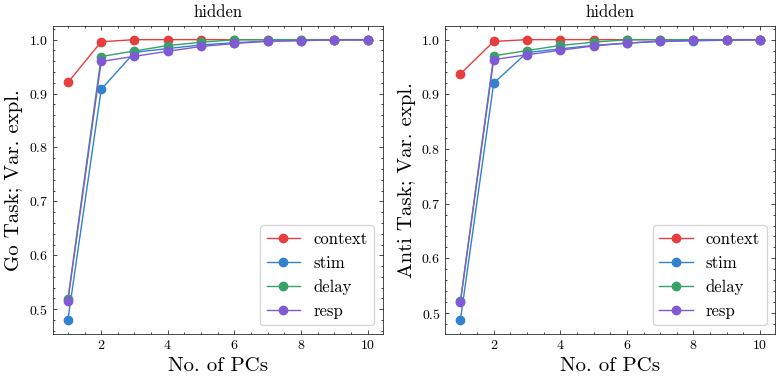

In [24]:
data_all = [["hidden", res_H]]
pcs = {}
for name, res in data_all: 
    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    for task_index in range(2):
        for period_index in range(4):
            evr_curve = res[task_index]["evr_curves"][period_index]
            period_name = res[task_index]["period_names"][period_index]
            cev = np.cumsum(evr_curve, axis=0)
            axs[task_index].plot([i+1 for i in range(len(cev))], cev, "-o", color=c_vals[period_index], label=period_name)
            pcs[f"{name}_task{task_index}_{period_name}"] = cev
            
    axs[0].set_ylabel("Go Task; Var. expl.", fontsize=15)
    axs[1].set_ylabel("Anti Task; Var. expl.", fontsize=15)
    for ax in axs:
        ax.set_xlabel("No. of PCs", fontsize=15)
        ax.legend(fontsize=12, frameon=True, loc="best")
        ax.set_title(name, fontsize=12)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/dimension_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

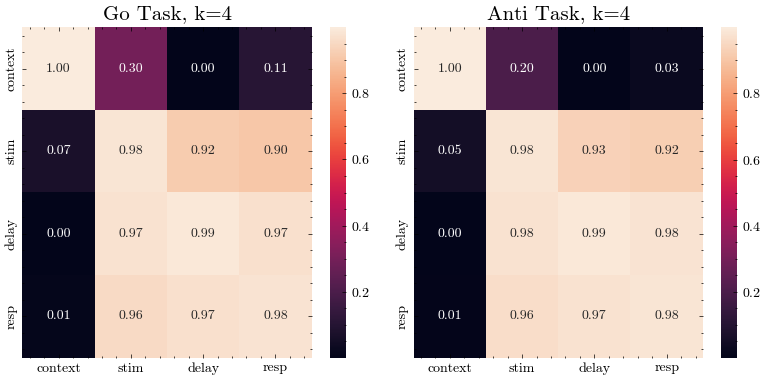

In [25]:
for name, res in data_all: 
    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    for task_index in range(2):
        fve_k = res[task_index]["fve_k"]
        sns.heatmap(fve_k, ax=axs[task_index], 
                    xticklabels=res_H[task_index]["period_names"], 
                    yticklabels=res_H[task_index]["period_names"],
                    annot=True, fmt=".2f")
    axs[0].set_title(f"Go Task, k={top_k}", fontsize=15)
    axs[1].set_title(f"Anti Task, k={top_k}", fontsize=15)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/d_separate_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

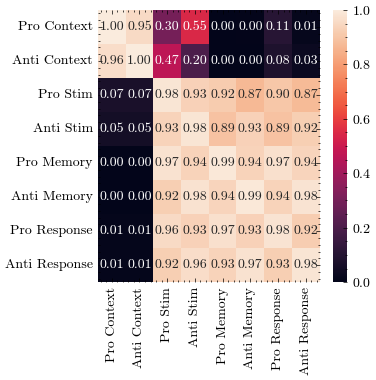

In [26]:
fve_k_alls = []

for name, res in data_all: 
    fig, axs = plt.subplots(1,1,figsize=(4*1,4))
    fve_k_all = res["__cross_task__"]["fve_k_all"]
    labels_all = res["__cross_task__"]["labels"]
    
    permute = [0,4,1,5,2,6,3,7]
    fve_k_all = fve_k_all[np.ix_(permute, permute)]
    labels_all = [labels_all[i] for i in permute]
    
    labels_alt = ["Pro Context", "Anti Context", "Pro Stim", "Anti Stim",
                 "Pro Memory", "Anti Memory", "Pro Response", "Anti Response"]
    
    sns.heatmap(fve_k_all, ax=axs, 
                xticklabels=labels_alt,
                yticklabels=labels_alt,
                annot=True, fmt=".2f", vmin=0.0, vmax=1.0)

    fve_k_alls.append(fve_k_all)
    
    # axs.set_title(f"Go/Anti Task", fontsize=15)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/d_combine_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

In [27]:
import pickle 

learning_hm_similarity = {
    "break_names": break_names, 
    "counter_lst": counter_lst, 
    "result_attractor_all_h": result_attractor_all_h, 
}

save_all = {
    "learning_hm_similarity": learning_hm_similarity, 
    "pcs": pcs,
    "fve_k_alls": fve_k_alls
}

filename = f"twotasks_data/seed{seed}_{hyp_dict['addon_name']}.pkl"
with open(filename, "wb") as f:
    pickle.dump(save_all, f, protocol=pickle.HIGHEST_PROTOCOL)